# API Project - Data Collection and Preparation 
# Aida Sehic

In [1]:
import os
import urllib.request
import csv
import pandas as pd 
import json
import datetime
#from datetime import datetime
import numpy as np
from sklearn.base import TransformerMixin
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from pandas.tools.plotting import scatter_matrix
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import seaborn as sns
import matplotlib.collections as collections

/Users/aidasehic/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Task 1: Identify one or more suitable web APIs

#### Choose one or more open web APIs as your source of data. If you decide to use more than one API, the APIs should be related in some way.

APIs Chosen:

Two APIs sources were chosen for this assignment, provided by:

1) https://www.cryptocompare.com/api/#introduction
Specifically, the historic 'HistoDay' daily data API - https://www.cryptocompare.com/api/#-api-data-histoday

--> Retrieves open, high, low, close, volumefrom and volumeto daily historical data for cryptocurrency of your choice. The values are based on 00:00 GMT time. It uses BTC conversion if data is not available because the coin is not trading in the specified currency.

2) http://open-platform.theguardian.com/
Specifically, all pieces of content on Bitcoin published in last year (since 2017-04-01) in the API - 
https://content.guardianapis.com/search?q=bitcoin&from-date=2017-04-01&to-date=2018-03-31&order-by=newest&show-fields=all&page-size=200&api-key=9d7f80a7-70ae-4b38-b22b-7a0c58c31c16

How it works: The Open Platform is a public web service for accessing all the content the Guardian creates, categorised by tags and section. To get started, You need an key to successfully authenticate against the API.
The level of access I chose is Developer as it is free for non-commercial usage. I have register developer key at 
https://bonobo.capi.gutools.co.uk/register/developer

(Up to 12 calls per second, Up to 5,000 calls per day, Access to article text, Access to over 1,900,000 pieces of content, Free for non-commercial usage)

The API key I received which works here is 9d7f80a7-70ae-4b38-b22b-7a0c58c31c16

## Task 2 & Task 3: Collecting data your chosen API(s) & Parsing the collected data, and store it in an appropriate file format

#### Collect data from your chosen API(s) using Python. Your dataset should contain at least 100 records/items in total. Depending on the API(s), you may need to repeat the collection process multiple times to download sufficient data.
#### Parse the collected data, and store it in an appropriate file format for subsequent analysis (e.g. JSON, CSV, XML).

#### CryptoCompare API Parameters

Endpoint URL: https://min-api.cryptocompare.com/data/histoday?

fsym -	REQUIRED The cryptocurrency symbol of interest [Max character length: 10] -->  BTC and ETH

tsym -	REQUIRED The currency symbol to convert into [Max character length: 10] --> I have selected EUR

limit -	The number of data points to return --> 364 (returns 365 days of data)

toTs -	Last unix timestamp to return data for --> 1522454400 (equivalent to 2018-03-31)

In [2]:
url_btc='https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=EUR&limit=364&toTs=1522454400'
response_btc = urllib.request.urlopen(url_btc)
raw_json_btc = response_btc.read().decode("utf-8")
data_btc = json.loads(raw_json_btc)

url_eth = 'https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=EUR&limit=364&toTs=1522454400'
response_eth = urllib.request.urlopen(url_eth)
raw_json_eth = response_eth.read().decode("utf-8")
data_eth = json.loads(raw_json_eth)

#### The Guardian API Parameters

Endpoint URL: https://content.guardianapis.com/search

api-key - The API key used for the query (retrieved key for which I registered) --> mine is 9d7f80a7-70ae-4b38-b22b-7a0c58c31c16

q - Request content containing this free text. Supports AND, OR and NOT operators, and exact phrase queries using double quotes. --> bitcoin

use-date -	Changes which type of date is used to filter the results using from-date (2017-04-01) and to-date (2018-03-31)

order-by	Returns results in the specified order (relevance - Default where q parameter is specified,
oldest, newest - Default in all other cases)  --> I have slected newest, as default would be relevance due to the fact
that q is specified

show-fields - Add fields associated with the content  --> all 

page-size - Modify the number of items displayed per page --> 200

In [3]:
api_key = "9d7f80a7-70ae-4b38-b22b-7a0c58c31c16"

In [4]:
url1 = 'https://content.guardianapis.com/search?q=bitcoin&from-date=2017-11-18&to-date=2018-03-31&order-by=newest&show-fields=all&page-size=200&api-key=' + api_key
response1 = urllib.request.urlopen(url1)
raw_json1 = response1.read().decode("utf-8")
data1 = json.loads(raw_json1)

url2 = 'https://content.guardianapis.com/search?q=bitcoin&from-date=2017-04-01&to-date=2017-11-17&order-by=newest&show-fields=all&page-size=200&api-key=' + api_key
response2 = urllib.request.urlopen(url2)
raw_json2= response2.read().decode("utf-8")
data2 = json.loads(raw_json2)

## Task 4: Load and represent the data using an appropriate data structure. Apply any pre-processing steps to clean/filter/combine the data

#### Load and represent your data as a Pandas DataFrame. Apply any pre-processing and quality checking steps that may be required to clean and filter the data before analysis.

In [5]:
df_btc = pd.DataFrame(data_btc['Data'])
df_eth = pd.DataFrame(data_eth['Data'])

In [6]:
df_1 = pd.DataFrame(data1['response']['results'])
df_2 = pd.DataFrame(data2['response']['results'])

In [7]:
#converting unix timestamp string to readable date.
for i in range(len(df_btc['time'])):
    t1=df_btc['time'][i]
    df_btc['time'][i]= datetime.datetime.fromtimestamp(int(t1)).strftime('%Y-%m-%d') 
    t2=df_eth['time'][i]
    df_eth['time'][i]= datetime.datetime.fromtimestamp(int(t2)).strftime('%Y-%m-%d')   

##### Preforming some Data Modification - adding new 'Cryptocurrency' column to cryptoCompare data in order to specify the name of the cryptocurrancy

In [8]:
df_btc.insert(0, 'Cryptocurrency', 'BTC')
df_eth.insert(0, 'Cryptocurrency', 'ETH')

In [9]:
df_btc[0:5]

,Cryptocurrency,close,high,low,open,time,volumefrom,volumeto
0,BTC,1018.38,1034.13,994.90,1006.92,2017-04-01,10478.22,10626257.52
1,BTC,1028.39,1039.13,1005.02,1018.38,2017-04-02,10959.66,11233202.19
2,BTC,1073.27,1083.67,1026.09,1028.39,2017-04-03,16688.87,17717245.72
3,BTC,1065.98,1089.25,1050.91,1073.27,2017-04-04,13753.22,14712324.04
4,BTC,1060.21,1070.67,1041.16,1065.98,2017-04-05,11582.52,12227442.32


In [10]:
df_eth[0:5]

,Cryptocurrency,close,high,low,open,time,volumefrom,volumeto
0,ETH,47.14,48.26,45.00,46.41,2017-04-01,77701.26,3646477.03
1,ETH,45.04,47.75,44.35,47.14,2017-04-02,128859.70,5929318.69
2,ETH,41.29,45.18,40.34,45.04,2017-04-03,205515.53,8771670.64
3,ETH,41.38,42.98,38.40,41.29,2017-04-04,218349.23,8840762.95
4,ETH,42.23,44.26,41.25,41.38,2017-04-05,106253.87,4589114.97


##### Preforming some Data Modification - merging data for Bitcoin and Ethereum within the same dataframe, and doing the same for gardian data from different time frames

In [11]:
df1 = df_btc.append(df_eth,ignore_index=True)
df2 = df_1.append(df_2,ignore_index=True)

In [12]:
print(df_btc.shape)
print(df_eth.shape)
print(df1.shape)
#print(df_eth)
#print(df_btc)
#print(df1)

print(df_1.shape)
print(df_2.shape)
print(df2.shape)
#print(df_eth)
#print(df_btc)
#print(df2)

(365, 8)
(365, 8)
(730, 8)
(199, 12)
(121, 12)
(320, 12)


In [13]:
df1[0:5]

,Cryptocurrency,close,high,low,open,time,volumefrom,volumeto
0,BTC,1018.38,1034.13,994.90,1006.92,2017-04-01,10478.22,10626257.52
1,BTC,1028.39,1039.13,1005.02,1018.38,2017-04-02,10959.66,11233202.19
2,BTC,1073.27,1083.67,1026.09,1028.39,2017-04-03,16688.87,17717245.72
3,BTC,1065.98,1089.25,1050.91,1073.27,2017-04-04,13753.22,14712324.04
4,BTC,1060.21,1070.67,1041.16,1065.98,2017-04-05,11582.52,12227442.32


In [14]:
df2[0:5]

,apiUrl,fields,id,isHosted,pillarId,pillarName,sectionId,sectionName,type,webPublicationDate,webTitle,webUrl
0,https://content.guardianapis.com/books/shortcu...,{'headline': 'Harry Potter books turn out to b...,books/shortcuts/2018/mar/28/harry-potter-books...,False,pillar/arts,Arts,books,Books,article,2018-03-28T15:37:32Z,Harry Potter books turn out to be a wizard inv...,https://www.theguardian.com/books/shortcuts/20...
1,https://content.guardianapis.com/books/austral...,{'headline': 'The Darkest Web: exploring the u...,books/australia-books-blog/2018/mar/22/the-dar...,False,pillar/arts,Arts,books,Books,article,2018-03-21T17:00:11Z,The Darkest Web: exploring the ugly world of i...,https://www.theguardian.com/books/australia-bo...
2,https://content.guardianapis.com/uk-news/2018/...,{'headline': 'Manchester students jailed for s...,uk-news/2018/mar/21/manchester-students-jailed...,False,pillar/news,News,uk-news,UK news,article,2018-03-21T16:47:22Z,Manchester students jailed for selling £800k o...,https://www.theguardian.com/uk-news/2018/mar/2...
3,https://content.guardianapis.com/global/2018/m...,{'headline': 'Delete your account – a guide to...,global/2018/mar/20/delete-your-account-a-guide...,False,pillar/news,News,technology,Technology,article,2018-03-20T17:22:16Z,Delete your account – a guide to life after Fa...,https://www.theguardian.com/global/2018/mar/20...
4,https://content.guardianapis.com/technology/20...,{'headline': 'Child abuse imagery found within...,technology/2018/mar/20/child-abuse-imagery-bit...,False,pillar/news,News,technology,Technology,article,2018-03-20T12:25:44Z,Child abuse imagery found within bitcoin's blo...,https://www.theguardian.com/technology/2018/ma...


##### Preforming further Data Modification - filtering Guardian data for only valuable information/metrics

In [15]:
list(df2.columns.values)

['apiUrl',
 'fields',
 'id',
 'isHosted',
 'pillarId',
 'pillarName',
 'sectionId',
 'sectionName',
 'type',
 'webPublicationDate',
 'webTitle',
 'webUrl']

In [16]:
df_final=df2[['webPublicationDate','webTitle','pillarName', 'sectionName']] #creating final guardian dataframe 
                                    #that contains only interesting columns

In [17]:
#adding additional columns to df_final guardian dataframe that will contained data from the 'fiels' 
#but only interesting data: trailText (description of the text), bodyText (entire text that could be later used
#for sentiment analysis), and lang (language)
df_fields_trailText=[]
df_fields_bodyText=[]
df_fields_lang=[]
for i in range(len(df2['fields'])):
    df_fields_trailText.append(df2['fields'][i]['trailText'])
    df_fields_bodyText.append(df2['fields'][i]['bodyText'])
    df_fields_lang.append(df2['fields'][i]['lang'])
    
fields_trailText_series=pd.Series(df_fields_trailText)
fields_bodyText_series=pd.Series(df_fields_bodyText)
fields_lang_series=pd.Series(df_fields_lang)

df_final['trailText']=fields_trailText_series.values
df_final['bodyText']=fields_bodyText_series.values
df_final['language']=fields_lang_series.values

In [18]:
print(list(df_final.columns.values))
#print(df_final)

['webPublicationDate', 'webTitle', 'pillarName', 'sectionName', 'trailText', 'bodyText', 'language']


In [19]:
#Renaming the name of the columns to more appropriate names
df_final.columns = ['time', 'title', 'category', 'section','description', 'text', 'language']
print(list(df_final.columns.values))
#print(df_final)

['time', 'title', 'category', 'section', 'description', 'text', 'language']


In [20]:
#using only date from the date/time format
date=[]
for i in range(len(df_final['time'])):
    s=df_final['time'][i]
    date_v,time=s.split('T')
    date.append(date_v)
#print(date)
date_series=pd.Series(date)
df_final['date']=date_series.values

df_final.drop('time', axis=1, inplace=True)

In [21]:
df_final[0:5]

,title,category,section,description,text,language,date
0,Harry Potter books turn out to be a wizard inv...,Arts,Books,A bookseller has been convicted of stealing a ...,News that Italian bookseller Rudolf Schönegger...,en,2018-03-28
1,The Darkest Web: exploring the ugly world of i...,Arts,Books,Eileen Ormsby was threatened with violence whe...,It’s an arresting concept: the idea that rippl...,en,2018-03-21
2,Manchester students jailed for selling £800k o...,News,UK news,Gang of five who compared themselves to Breaki...,A gang of students from the University of Manc...,en,2018-03-21
3,Delete your account – a guide to life after Fa...,News,Technology,Perhaps you think you can’t possibly replace t...,"For many people, deleting their Facebook accou...",en,2018-03-20
4,Child abuse imagery found within bitcoin's blo...,News,Technology,Researchers discover illegal content within th...,German researchers have discovered unknown per...,en,2018-03-20


In [22]:
# Extract date, category, section data for analysis and visualisation
# Data in 'text' and other columns could be used in some more detailed analysis, where we could do sentiment analysis
# on data in 'text', and 'title'
df_simplified = df_final[['date', 'category', 'section']] 
df_simplified[0:5]
#df_simplified.shape

,date,category,section
0,2018-03-28,Arts,Books
1,2018-03-21,Arts,Books
2,2018-03-21,News,UK news
3,2018-03-20,News,Technology
4,2018-03-20,News,Technology


##### Missing Data

Final Pre-Processing steps are to look for missing data to see if further pre-processing is needed.

In [23]:
#look for missing data
df1.isnull().sum() # no missing values in the cryptocompare dataset 

Cryptocurrency    0
close             0
high              0
low               0
open              0
time              0
volumefrom        0
volumeto          0
dtype: int64

In [24]:
df_simplified.isnull().sum() # There are some missing values in guardian data (6 missing values in the Category field)

date        0
category    6
section     0
dtype: int64

In [25]:
#Imputing missing values.
#Missing values in categorical fields are usually imputed with the most frequent value in the column.
#Numerical data columns are usually imputed with the mean of column.

#Creating a class that will preform dataframe missing data imputation

class dfImputer(TransformerMixin):
    def __init__(self):
        'Imputing missing values'        
    def fit(self, DF, y=None):
        self.fill = pd.Series([DF[column].value_counts().index[0]
            if DF[column].dtype == np.dtype('O') else DF[column].mean() for column in DF],
            index=DF.columns)
        return self
    def transform(self, DF, y=None):
        return DF.fillna(self.fill)

In [26]:
#Imputing missing values
df_simplified = dfImputer().fit_transform(df_simplified)
print(df_simplified.isnull().sum()) # there is no longer missing values in the guardian dataset

date        0
category    0
section     0
dtype: int64


In [27]:
print(df_btc.dtypes.value_counts()) 
print(df_eth.dtypes.value_counts()) 
print(df1.dtypes.value_counts()) #we need to convert column 'time' to datetime datatype (in cryptocompare data)

float64    6
object     2
dtype: int64
float64    6
object     2
dtype: int64
float64    6
object     2
dtype: int64


In [28]:
#converting column 'time' from object to datetime datatype (in cryptocompare)
df_btc['time'] = pd.to_datetime(df_btc['time'])
df_eth['time'] = pd.to_datetime(df_eth['time'])
df1['time'] = pd.to_datetime(df1['time'])
#print(df_btc.dtypes.value_counts()) 
#print(df_eth.dtypes.value_counts()) 
#print(df1.dtypes.value_counts()) 

In [29]:
df_simplified.dtypes.value_counts() #we need to convert column 'date' from object to datetime datatype
#object	string	The most general dtype. Will be assigned to your column if column has mixed types (numbers and strings).

object    3
dtype: int64

In [30]:
#converting column 'time' from object to datetime datatype
df_simplified['date'] = pd.to_datetime(df_simplified['date'])
df_simplified.dtypes.value_counts()

object            2
datetime64[ns]    1
dtype: int64

In [31]:
df1[0:5]

,Cryptocurrency,close,high,low,open,time,volumefrom,volumeto
0,BTC,1018.38,1034.13,994.90,1006.92,2017-04-01,10478.22,10626257.52
1,BTC,1028.39,1039.13,1005.02,1018.38,2017-04-02,10959.66,11233202.19
2,BTC,1073.27,1083.67,1026.09,1028.39,2017-04-03,16688.87,17717245.72
3,BTC,1065.98,1089.25,1050.91,1073.27,2017-04-04,13753.22,14712324.04
4,BTC,1060.21,1070.67,1041.16,1065.98,2017-04-05,11582.52,12227442.32


In [32]:
df_simplified[0:5]

,date,category,section
0,2018-03-28,Arts,Books
1,2018-03-21,Arts,Books
2,2018-03-21,News,UK news
3,2018-03-20,News,Technology
4,2018-03-20,News,Technology


##### The final Pre-processing step is to get Monthly averages to create a reduced size data set that can be easier visualised, but still accurate and indicative of the months open, close, high, low and numbers of monthly publications.

In [33]:
monthly = df_btc.groupby([pd.Grouper(key='time',freq='M')]) # http://stackoverflow.com/questions/32982012/grouping-dataframe-by-custom-date
avg_month_btc = monthly.mean() #create a new DF based on the mean of the groupby object created above
avg_month_btc[0:5]

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2017-04-30,1131.136333,1143.549333,1110.075000,1123.823000,9976.129000,1.123679e+07
2017-05-31,1690.059032,1767.718710,1606.011935,1663.284194,25548.403871,4.490017e+07
2017-06-30,2324.023333,2403.363000,2229.516000,2320.822000,21540.981000,4.979395e+07
2017-07-31,2183.522258,2250.562581,2099.184516,2173.222258,17804.230323,3.801167e+07
2017-08-31,3289.535484,3363.991935,3144.496452,3240.603548,16142.858710,5.217351e+07


In [34]:
monthly = df_eth.groupby([pd.Grouper(key='time',freq='M')]) # http://stackoverflow.com/questions/32982012/grouping-dataframe-by-custom-date
avg_month_eth = monthly.mean() #create a new DF based on the mean of the groupby object created above
avg_month_eth[0:5]

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2017-04-30,46.673333,47.950000,44.629667,45.853667,98778.794333,4.780457e+06
2017-05-31,109.080000,122.470323,96.592258,104.840323,196118.061935,2.363538e+07
2017-06-30,269.602000,281.896667,247.582333,268.201667,184205.626667,4.850857e+07
2017-07-31,192.181290,204.866452,180.256129,194.478710,186918.077419,3.411774e+07
2017-08-31,255.208387,261.722258,244.385161,250.255161,99830.297742,2.504114e+07


# Task 5: Analyse and summarise the cleaned dataset

##### Analyse and summarise the cleaned dataset, using tables and plots where appropriate. Based on your results, what interpretations or insights can be made about the dataset? What further analysis might be done on the data? Detail this using Markdown cells in your notebook.

Descriptive Statistics

Initially of the Data Set containing all daily data:

In [35]:
print("Bitcoin daily historical data: \n\ndf_btc columnns:\n" +  str(df_btc.columns.values) + "\n")
print("df_btc Descriptive Stats:")
print(df_btc.describe())

Bitcoin daily historical data: 

df_btc columnns:
['Cryptocurrency' 'close' 'high' 'low' 'open' 'time' 'volumefrom'
 'volumeto']

df_btc Descriptive Stats:
              close          high           low          open     volumefrom  \
count    365.000000    365.000000    365.000000    365.000000     365.000000   
mean    5304.806712   5525.013123   5024.546521   5291.945151   20093.251918   
std     3710.820130   3903.847820   3458.650518   3717.269652   12689.229163   
min     1018.380000   1034.130000    994.900000   1006.920000    2074.920000   
25%     2249.870000   2324.150000   2182.500000   2248.930000   12007.500000   
50%     3820.260000   3896.410000   3694.680000   3780.820000   17329.980000   
75%     7526.650000   7856.600000   7117.980000   7525.250000   24708.210000   
max    16376.300000  16670.940000  15760.450000  16374.540000  104667.240000   

           volumeto  
count  3.650000e+02  
mean   1.157854e+08  
std    1.339683e+08  
min    4.262280e+06  
25%    3.5534

In [36]:
print("Bitcoin average monthly historical data: \n\n avg_month_btc columnns:\n" +  str(avg_month_btc.columns.values) + "\n")
print("avg_month_btc Descriptive Stats:")
print(avg_month_btc.describe())

Bitcoin average monthly historical data: 

 avg_month_btc columnns:
['close' 'high' 'low' 'open' 'volumefrom' 'volumeto']

avg_month_btc Descriptive Stats:
              close          high           low          open    volumefrom  \
count     12.000000     12.000000     12.000000     12.000000     12.000000   
mean    5302.818120   5523.441055   5022.547702   5289.845626  20164.562696   
std     3727.237712   3931.113727   3459.164108   3731.680388   6754.774244   
min     1131.136333   1143.549333   1110.075000   1123.823000   9367.661935   
25%     2288.898065   2365.162895   2196.933129   2283.922065  17366.206927   
50%     4006.045656   4106.086489   3856.068091   3980.929989  20433.453167   
75%     7371.693891   7710.071037   7043.913810   7436.970372  23142.807903   
max    12756.584194  13403.705484  11765.480000  12650.484516  32854.449286   

           volumeto  
count  1.200000e+01  
mean   1.161929e+08  
std    1.050618e+08  
min    1.123679e+07  
25%    4.411448e+07  


Bitcoin: As can be seen from comparing both descriptive stats, the monthly average, seems to have removed outliers (e.g. max volumefrom: 104667.24 vs 32854.45), has reduced the standard deviation for volumefrom (from 12689.23 to 6754.77), but the quartiles have remained largely the same.

In [37]:
print("Etherium daily historical data: \n\ndf_eth columnns:\n" +  str(df_eth.columns.values) + "\n")
print("df_eth Descriptive Stats:")
print(df_eth.describe())

Etherium daily historical data: 

df_eth columnns:
['Cryptocurrency' 'close' 'high' 'low' 'open' 'time' 'volumefrom'
 'volumeto']

df_eth Descriptive Stats:
             close         high          low         open     volumefrom  \
count   365.000000   365.000000   365.000000   365.000000     365.000000   
mean    358.981863   376.706685   337.421781   358.206603  121343.145863   
std     248.862124   262.565644   232.759017   249.336813   96662.308092   
min      39.660000    41.880000    38.400000    39.660000    2927.840000   
25%     209.500000   221.820000   188.690000   202.520000   62327.110000   
50%     264.550000   278.650000   252.790000   264.210000   94256.850000   
75%     528.040000   567.340000   462.810000   528.040000  150084.680000   
max    1144.050000  1175.650000  1062.600000  1144.050000  564015.690000   

           volumeto  
count  3.650000e+02  
mean   4.097413e+07  
std    4.557493e+07  
min    7.501785e+05  
25%    1.497569e+07  
50%    2.830199e+07  
75% 

In [38]:
print("Etherium average monthly historical data: \n\n avg_month_eth columnns:\n" +  str(avg_month_eth.columns.values) + "\n")
print("avg_month_eth Descriptive Stats:")
print(avg_month_eth.describe())

Etherium average monthly historical data: 

 avg_month_eth columnns:
['close' 'high' 'low' 'open' 'volumefrom' 'volumeto']

avg_month_eth Descriptive Stats:
            close        high         low        open     volumefrom  \
count   12.000000   12.000000   12.000000   12.000000      12.000000   
mean   360.232600  378.046120  338.594175  359.517693  121444.661848   
std    250.680459  264.180475  233.262459  250.648243   48145.764254   
min     46.673333   47.950000   44.629667   45.853667   32332.305806   
25%    235.741073  247.508306  222.753782  236.311048   96864.867667   
50%    264.641000  273.599140  250.207296  263.818575  115472.124172   
75%    511.741532  536.498387  488.581048  518.769758  144149.959167   
max    898.774194  947.532903  831.116129  890.339355  196118.061935   

           volumeto  
count  1.200000e+01  
mean   4.121105e+07  
std    3.091471e+07  
min    4.780457e+06  
25%    2.468970e+07  
50%    3.172619e+07  
75%    5.084115e+07  
max    1.096586e+0

Etherium: As can be seen from comparing both descriptive stats, the monthly average, seems to have removed outliers (e.g. max volumefrom: 564015.69 vs 196118.06), has reduced the standard deviation for volumefrom (from 96662.31 to 48145.76), but the quartiles have remained largely the same.

### Bitcoing and Etherium Closing Price Trend over One Year

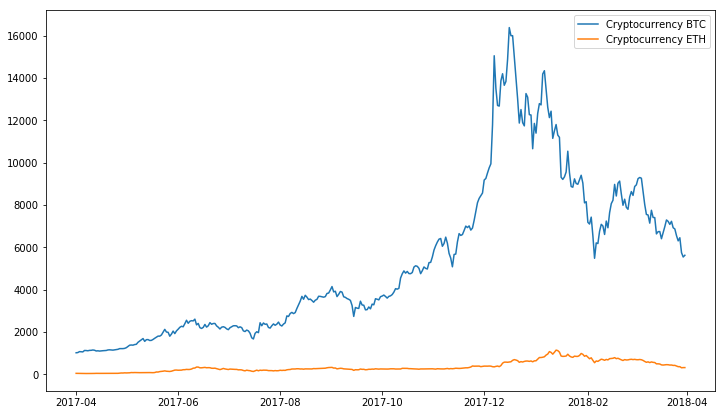

In [39]:
fig, ax = plt.subplots(figsize=(12,7))
df_plot=df1[['close','Cryptocurrency','time']]

for key, grp in df_plot.groupby(['Cryptocurrency']): 
    ax.plot(grp['time'], grp['close'],label = 'Cryptocurrency %s' % (key))
plt.legend(loc='best')
plt.show()

Bitcoing and Etherium Trend over One Year: close, high, low, open, volumefrom, volume to

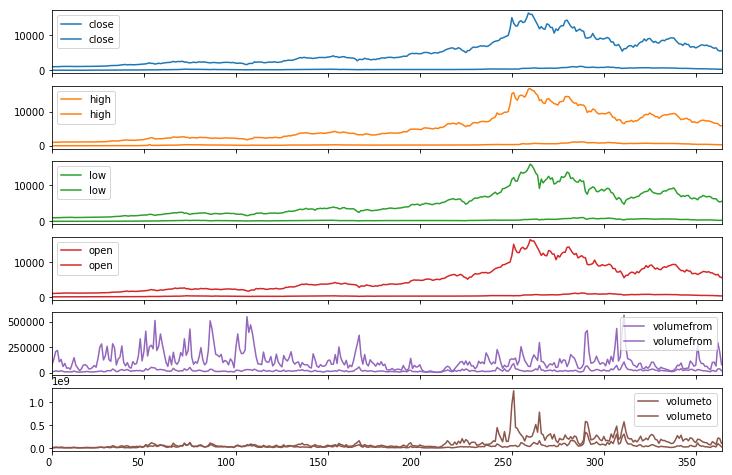

In [40]:
ax=df_btc.plot(subplots=True,figsize=(12,9))
df_eth.plot(subplots=True,figsize=(12,9),ax=ax)

plt.show()

### ScatterPlots

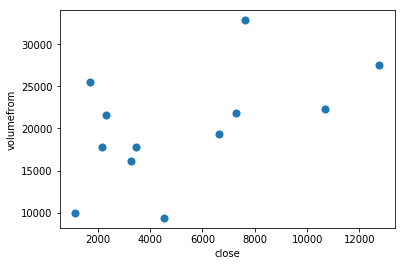

In [41]:
avg_month_btc.plot.scatter(x="close", y="volumefrom", s=50 )

/Users/aidasehic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.



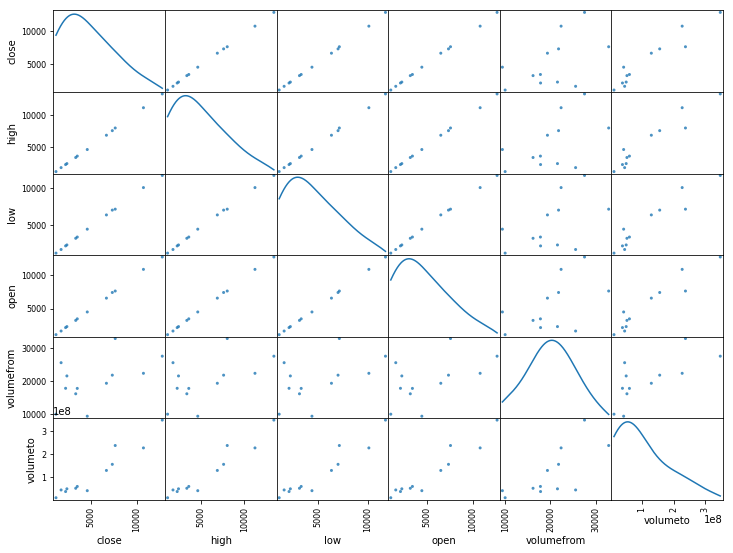

In [42]:
scatter_matrix(avg_month_btc, alpha=0.8, figsize=(12, 9), diagonal='kde')
plt.show()

### Dual Axis Line Graphs

In [43]:
df_btc_plot=avg_month_btc[['volumefrom','close']]

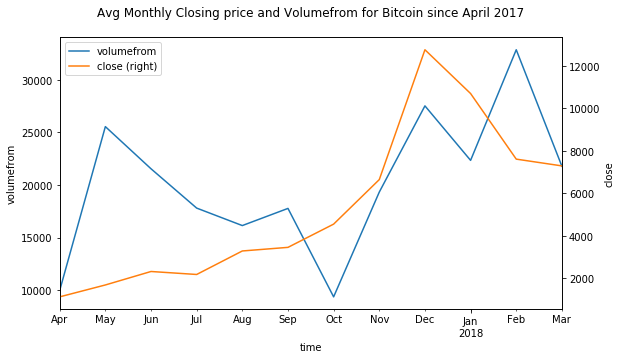

In [44]:
plt.figure()

ax = df_btc_plot.plot(secondary_y=['close'], figsize=(9, 5))
ax.set_ylabel("volumefrom")
ax.right_ax.set_ylabel("close")

plt.title("Avg Monthly Closing price and Volumefrom for Bitcoin since April 2017\n")
plt.xlabel("Time")

plt.show()

In [45]:
df_btc_plot=avg_month_btc[['low','high']]

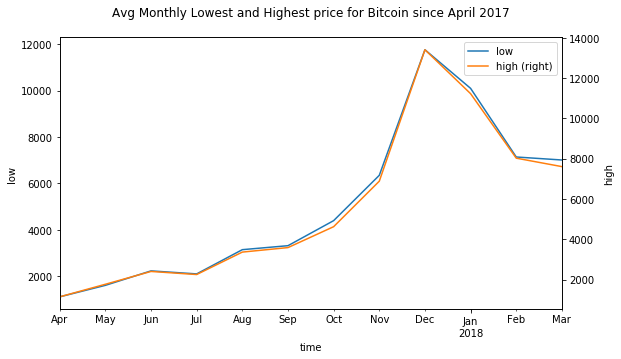

In [46]:
plt.figure()

ax = df_btc_plot.plot(secondary_y=['high'], figsize=(9, 5))
ax.set_ylabel("low")
ax.right_ax.set_ylabel("high")

plt.title("Avg Monthly Lowest and Highest price for Bitcoin since April 2017\n")
plt.xlabel("Time")

plt.show()

The difference between low and high Bitcoin value has never been higher

In [47]:
df_btc_plot=avg_month_btc[['volumefrom','volumeto']]

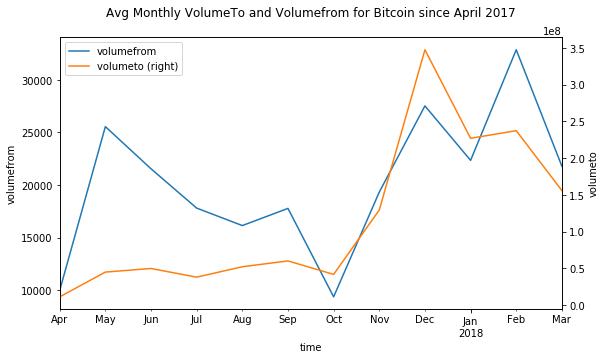

In [48]:
plt.figure()

ax = df_btc_plot.plot(secondary_y=['volumeto'], figsize=(9, 5))
ax.set_ylabel("volumefrom")
ax.right_ax.set_ylabel("volumeto")

plt.title("Avg Monthly VolumeTo and Volumefrom for Bitcoin since April 2017\n")
plt.xlabel("Time")

plt.show()

##### The Open-High-Low-Close chart is typically used to show the change in price over a period of time. 

In [49]:
btc_trace1 = go.Scatter(x=df_btc['time'], y=df_btc['high'],mode = 'lines+markers',name = 'BTC high')
btc_trace2 = go.Scatter(x=df_btc['time'], y=df_btc['low'],mode = 'lines+markers',name = 'BTC low')
btc_trace3 = go.Scatter(x=df_btc['time'], y=df_btc['open'],mode = 'lines',name = 'BTC open')
btc_trace4 = go.Scatter(x=df_btc['time'], y=df_btc['close'],mode = 'lines',name = 'BTC close')

py.iplot([btc_trace1,btc_trace2,btc_trace3,btc_trace4])

#### OHLC charts
A vertical line in OHLC chart shows the difference between the highest and the lowest price.
Generally, the longer the vertical line in OHLC chart, the more intense the trading. 

A tickmark on the left side of the OHLC chart indicates the opening price and 
a tickmark on the rightside indicates the closing price.
A green color represents that the closing price is higher than the opening price. 
A red color signifies the opposite (closing price is lower than the opening price). 

OHLC charts are a visual aid for decision making in trading as it identifies trends. 

In [50]:
trace1 = go.Ohlc(x=df_btc['time'],
                open=df_btc['open'],
                high=df_btc['high'],
                low=df_btc['low'],
                close=df_btc['close'],
                name = 'BTC OHLC')
data1 = [trace1]

trace2 = go.Ohlc(x=df_eth['time'],
                open=df_eth['open'],
                high=df_eth['high'],
                low=df_eth['low'],
                close=df_eth['close'],
                name = 'ETH OHLC',
                increasing=dict(line=dict(color= '#17BECF')),
                decreasing=dict(line=dict(color= '#7F7F7F')))
data2 = [trace2]
layout = {
    'title': 'OHLC Chart for BTC (red-green) and ETH (blue-grey)',
    'yaxis': {'title': 'Price in EUR'}
}

py.iplot(dict(data=[trace1,trace2], layout=layout))
#py.iplot([trace1])
layout2 = {
    'title': 'OHLC Chart for ETH (blue-grey)',
    'yaxis': {'title': 'Price in EUR'}
}
py.iplot(dict(data=[trace2], layout=layout2))

#### OHLC chart - zooming into December

In [51]:
from datetime import datetime
dates= []
for i in range(1,31):
    dates.append(datetime(year=2017, month=12, day=i))
trace1 = go.Ohlc(x=dates,
                open=df_btc['open'],
                high=df_btc['high'],
                low=df_btc['low'],
                close=df_btc['close'],
                name = 'BTC OHLC')
data1 = [trace1]

trace2 = go.Ohlc(x=dates,
                open=df_eth['open'],
                high=df_eth['high'],
                low=df_eth['low'],
                close=df_eth['close'],
                name = 'ETH OHLC',
                increasing=dict(line=dict(color= '#17BECF')),
                decreasing=dict(line=dict(color= '#7F7F7F')))
data2 = [trace2]

layout = {
    'title': 'OHLC Chart - December 2017',
    'yaxis': {'title': 'Price in EUR'}
}

py.iplot(dict(data=[trace1], layout=layout))
py.iplot(dict(data=[trace2], layout=layout))

Calculating the size of the vertical line in OHLC chart - the difference between the highest and lowest avg price in a month.
Generally, the longer the vertical line in OHLC chart, the more intense the trading. 

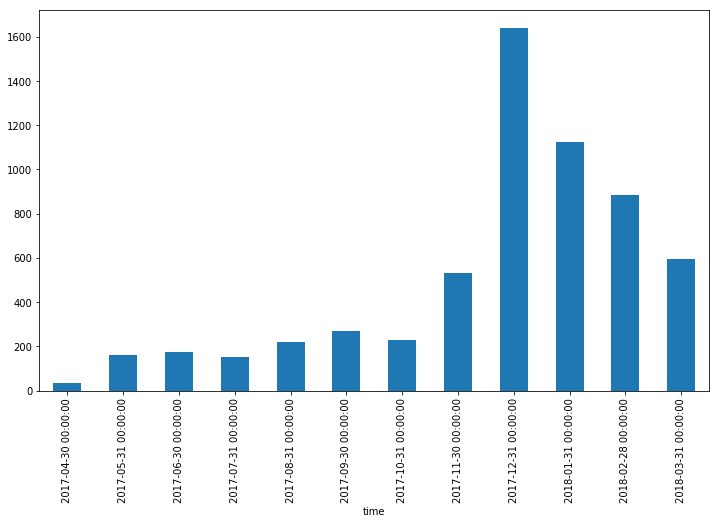

In [52]:
hl_diff=avg_month_btc['high']-avg_month_btc['low']
ax = hl_diff.plot(kind='bar', figsize=(12,7))

The most intense period for trading was in December and January.

Calculating the difference between the closing and opening price - having the difference bellow zero meanes that the price dropped

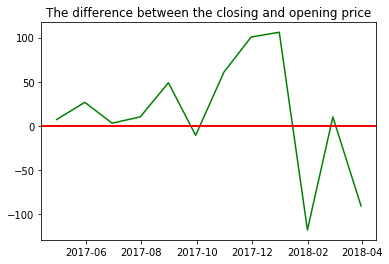

In [53]:
oc_diff=avg_month_btc['close']-avg_month_btc['open']
fig, ax = plt.subplots()
ax.set_title('The difference between the closing and opening price')
ax.plot( oc_diff, color='green')
ax.axhline(0, color='red', lw=2)
plt.show()

Difference between average closing and opening price per month has dropped significantly in the last few months

### Articles about Bitcoin

Gaining some insights from guardian data...

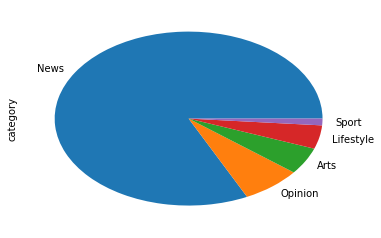

In [54]:
#Most common category - pie chart
df_simplified['category'].value_counts().plot(kind='pie')

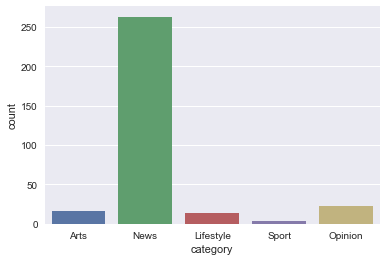

In [55]:
#Most common category - bar chart
sns.set(style="darkgrid")
ax = sns.countplot(x="category", data=df_simplified)

Content regarding Bitcoin was mostly published within category 'News', followed by 'Opinion'.

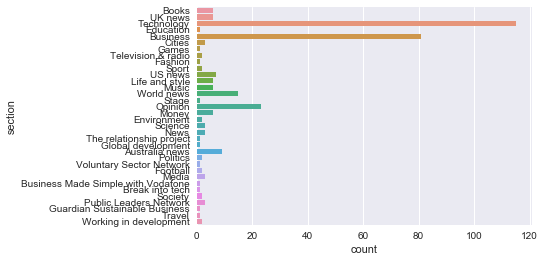

In [56]:
#Most common section - horizontal bar chart
ax = sns.countplot(y="section", data=df_final)

Bitcoin content was mostly published within section 'Technology', followed by 'Business' and 'Opinion.

### Bitcoin: Number of Published Articles vs Changes in Price

In [57]:
#category and section are categorical columns so we will just 
#count the number of rows (number of publications that month)
df_month=df_simplified.groupby([pd.Grouper(key='date',freq='M')]).count() 
df_month.drop('section', axis=1, inplace=True)
df_month.columns = ['number of articles']
#df_month[0:5]

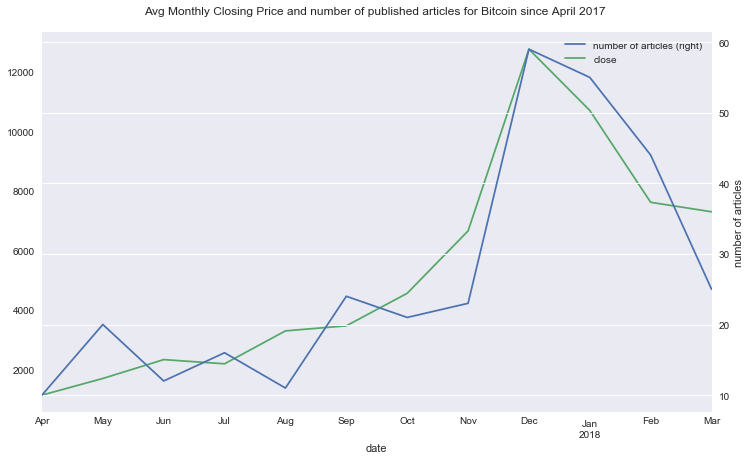

In [58]:
ax=df_month.plot(secondary_y='number of articles', kind='line', figsize=(12,7))
avg_month_btc.plot(y='close',kind='line', figsize=(12,7),ax=ax)
ax.set_ylabel("number of articles")

plt.title("Avg Monthly Closing Price and number of published articles for Bitcoin since April 2017 \n")
plt.xlabel("Time")
plt.show()

## Conclusion

It appears that there is a correlation between the Bitcoin price and the number of published articles about Bitcoin.

##### What further analysis might be done on the data?

Further in-depth studies and tests could be carried out to make statistically significant results.

- Preforming sentiment analysis on Guardian data (df_final['text']) via neural networks in order to conclude what type of news (positive or negative) have influence on prices
- Retrieving additional data from CryptoCompare and Guardian for other cryptocurrencies and observing even larger chunk of historical data.
- Retrieving additional metrics around market cap and volume 24h to get a better scope of the problem I observe
- Calculating Pearson correlation coefficient between different cryptocurrencies in order to conclude weather their price changes are correlated